In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import sys
sys.path.append("../scripts")

In [212]:
%%writefile "../scripts/utils.py"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import progressbar
import time

class ProgressBar:
    def __init__(self, max_value):
        time.sleep(0.5)
        self.bar = progressbar.ProgressBar(
            min_value=0,
            max_value=max_value,
            initial_value=0,
            widgets = [progressbar.SimpleProgress(), 
                       progressbar.Bar(), 
                       progressbar.Percentage()])
        self.bar.update(0)
        self.counter = 0
    
    def update(self):
        self.bar.update(self.counter + 1)
        self.counter += 1
        
    def finish(self):
        self.bar.finish()       

def flatten(x):
    return [z for y in x for z in y]

def plot_grid(df, n_cols, figsize):
    n_rows = int(np.ceil(len(df.columns)/n_cols))
    df.plot(subplots=True, layout=(n_rows, n_cols), figsize=figsize)

def plot_fcst(fcst, train=None, test=None, ax=None):
    lower = fcst.yhat_lower.interpolate()
    upper = fcst.yhat_upper.interpolate()
    if ax is None:
        f, ax = plt.subplots(1, 1)
    if train is not None:
        train.plot(style="k.", ax=ax)
    if test is not None:
        test.plot(style="r.", ax=ax)
    fcst.yhat.plot(ax=ax)
    ax.fill_between(fcst.index, y1=lower, y2=upper, alpha=0.3)

def get_amount_info(df):
    amount_info = df.notna().sum().sort_values() / len(df)
    return amount_info

def get_forecastables(df, T=0.5, N=None):
    amount_info = get_amount_info(df)
    forecastable = (amount_info > T)
    if N is not None:
        forecastable = forecastable.tail(N)
    return df.loc[:, forecastable.index].copy()


Overwriting ../scripts/utils.py


In [221]:
%%writefile "../scripts/forecaster.py"

import numpy as np
import pandas as pd
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from fbprophet import Prophet
pd.plotting.register_matplotlib_converters()
from progress_bar import ProgressBar

class ProphetForecaster:
    def __init__(self, use_boxcox=True, prophet_config=dict()):
        self.models = dict()
        self.fcst = dict()
        self.lmbda_boxcox = dict()
        self.use_boxcox = use_boxcox
        self.prophet_config = prophet_config

    def fit(self, train_df):
        print("Fitting...")
        progress_bar = ProgressBar(len(train_df.columns))
        
        for item in train_df.columns:
            target = train_df[item].dropna()
            if self.use_boxcox:
                idx = target.index
                target, self.lmbda_boxcox[item] = boxcox(target)
                target = pd.Series(target, index=idx)
            target.index.name = "ds"
            target.name = "y"
            target = target.reset_index()
            self.models[item] = Prophet(**self.prophet_config)
            self.models[item].fit(target)
            progress_bar.update()
        progress_bar.finish()
        return self.models
            
    def predict(self, steps=365, freq="D"):
        print("Forecasting...")
        progress_bar = ProgressBar(len(self.models.items()))
        for item, model in self.models.items():
            future = model.make_future_dataframe(steps, freq=freq)
            pred = model.predict(future).set_index("ds")
            pred = pred[["yhat", "yhat_lower", "yhat_upper"]]
            self.fcst[item] = pred
            if self.use_boxcox:
                self.fcst[item] = inv_boxcox(
                    self.fcst[item], 
                    self.lmbda_boxcox[item])
            progress_bar.update()
        progress_bar.finish()
        fcst_df = pd.concat(self.fcst, axis=1).sort_index(axis=1)
        return fcst_df


Overwriting ../scripts/prophet_forecaster.py


In [207]:
import utils

In [29]:
plt.rcParams["figure.figsize"] = (14,4)

In [30]:
data = pd.read_csv("../data/base_limpia.csv", parse_dates=["tiempo", "fecha pedido", "fecha liq"])

In [31]:
data.head()

,tiempo,nro factura,cliente,categoria,tipo negocio,localidad,direccion,plaza/campaña,producto,nro pedido,...,u pedidas,kg pedidos,fecha liq,u entregadas,kg entregados,importe bruto,importe factura,sucursal,longitud,latitud
0,2017-05-29,93315173,200008870,a5,mayorista,santa fe,av del valle 7199,plaza,90746,2736812,...,1,1.250,2017-05-29,1,1.250,231.70,12421.88,santa fe,-60.691979,-31.602638
1,2017-06-14,93368453,200008870,a5,mayorista,santa fe,av del valle 7199,plaza,90746,2765668,...,1,1.250,2017-06-14,1,1.250,231.70,19944.84,santa fe,-60.691979,-31.602638
2,2017-02-21,93074208,200008889,a3,supermercado,santa fe,gral.paz 5374,plaza,90740,2546672,...,2,1.464,2017-02-21,2,1.464,324.96,24534.07,santa fe,-60.686356,-31.620964
3,2017-05-11,93270490,200008889,a3,supermercado,santa fe,gral.paz 5374,plaza,90746,2702464,...,1,1.250,2017-05-11,1,1.250,231.70,27204.63,santa fe,-60.686356,-31.620964
4,2017-05-24,93309184,200008889,a3,supermercado,santa fe,gral.paz 5374,plaza,90746,2732609,...,1,1.250,2017-05-24,1,1.250,231.70,16573.12,santa fe,-60.686356,-31.620964


# Forecast por producto

In [32]:
u_producto = pd.pivot_table(
    data, 
    values="u pedidas", 
    index="tiempo", 
    columns="producto", 
    aggfunc="sum").asfreq("D")

In [17]:
u_producto.head()

producto,16034,16061,16062,16070,16071,16075,16076,16077,16080,16081,...,44151,44152,44154,44155,44157,44158,90739,90740,90745,90746
tiempo,,,,,,,,,,,,,,,,,,,,,
2017-01-02,NaN,7.0,1.0,25.0,11.0,3.0,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,1.0,NaN,NaN,4.0,1.0,NaN,NaN
2017-01-03,NaN,21.0,NaN,27.0,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,NaN,NaN
2017-01-04,NaN,NaN,NaN,8.0,4.0,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN
2017-01-05,NaN,3.0,NaN,6.0,3.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,10.0,NaN,1.0,NaN,1.0,NaN,NaN
2017-01-06,NaN,NaN,2.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
u_producto = u_producto.reindex(index=pd.date_range(start="2017-01-01", end="2019-12-31", freq="D"))

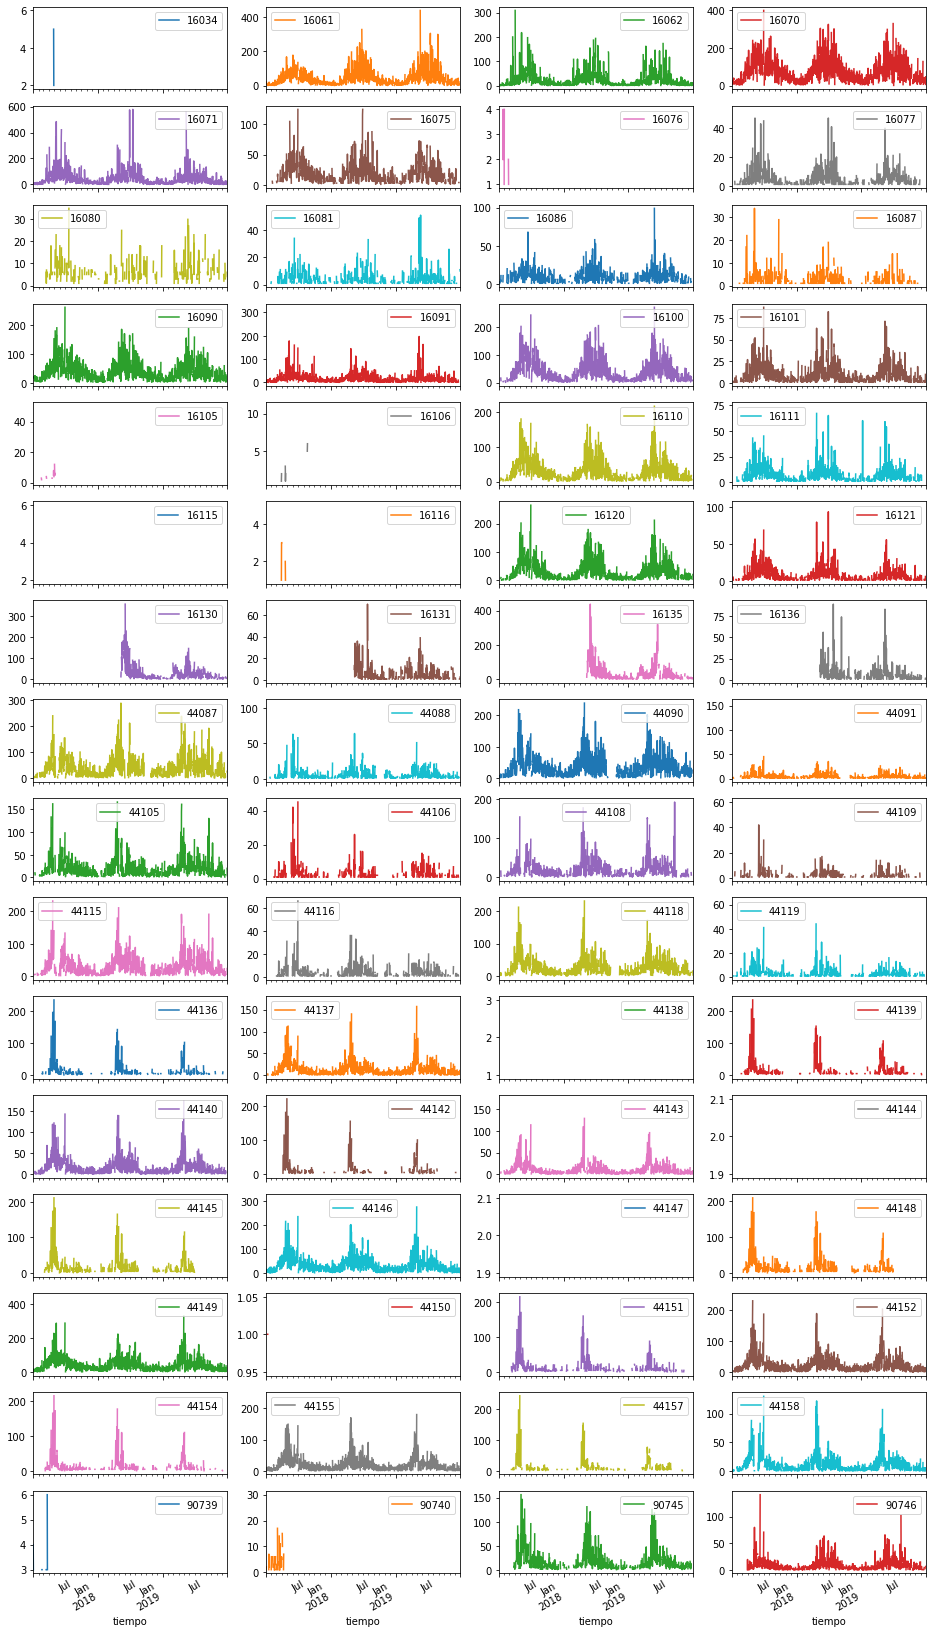

In [18]:
utils.plot_grid(u_producto, n_cols=4, figsize=(16,32))

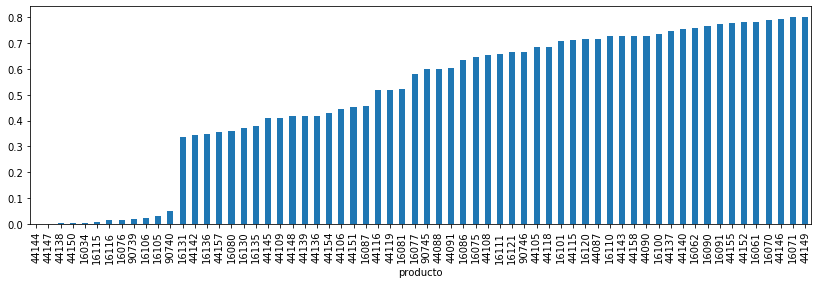

In [60]:
utils.get_amount_info(u_producto).plot(kind="bar")

In [61]:
u_producto_forecastable = utils.get_forecastables(u_producto, T=0.5, N=6)

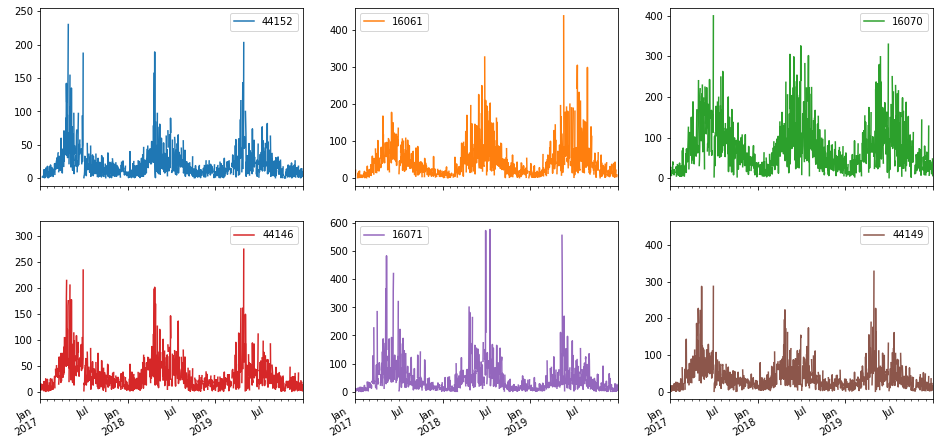

In [62]:
plot_grid(u_producto_forecastable, n_cols=3, figsize=(16, 8))

In [63]:
train, test = u_producto_forecastable[:"2018-12-31"], u_producto_forecastable["2019-01-01":]

In [64]:
from prophet_forecaster import ProphetForecaster

In [66]:
config = {
    "yearly_seasonality":10, 
    "weekly_seasonality":False, 
    "daily_seasonality":False}

model = ProphetForecaster(prophet_config=config)
model.fit(train)
fcst = model.predict(steps=365).asfreq("D")

Fitting...


6 of 6|###################################################################|100%


Forecasting...


6 of 6|###################################################################|100%


In [110]:
fcst.head(10)

44152                           16061                       \
           yhat_lower      yhat yhat_upper yhat_lower      yhat yhat_upper   
ds                                                                           
2017-01-02        NaN       NaN        NaN   2.186365  7.607492  21.738071   
2017-01-03        NaN       NaN        NaN   2.212606  7.655358  22.274882   
2017-01-04        NaN       NaN        NaN        NaN       NaN        NaN   
2017-01-05        NaN       NaN        NaN   2.142131  7.752606  21.240793   
2017-01-06        NaN       NaN        NaN        NaN       NaN        NaN   
2017-01-07        NaN       NaN        NaN   2.332209  7.819204  21.953607   
2017-01-08        NaN       NaN        NaN        NaN       NaN        NaN   
2017-01-09        NaN       NaN        NaN        NaN       NaN        NaN   
2017-01-10        NaN       NaN        NaN        NaN       NaN        NaN   
2017-01-11   1.419315  4.718857  13.877526   1.898200  7.730956  20.128951   

                16070                            44146                       \
           yhat_lower       yhat yhat_upper yhat_lower      yhat yhat_upper   
ds                                                                            
2017-01-02   5.050616  18.882908  49.931311   2.585728  8.136911  21.018490   
2017-01-03   4.325971  18.468423  51.177889   2.424195  7.933868  20.843918   
2017-01-04   4.742115  18.132702  48.747017   2.665345  7.758169  19.871241   
2017-01-05   4.373011  17.871038  46.850119   2.396236  7.610907  19.215422   
2017-01-06   4.448483  17.677949  46.972761        NaN       NaN        NaN   
2017-01-07   4.268750  17.547252  42.289747   2.426263  7.404455  19.322477   
2017-01-08        NaN        NaN        NaN        NaN       NaN        NaN   
2017-01-09        NaN        NaN        NaN        NaN       NaN        NaN   
2017-01-10   4.560600  17.458311  46.266242   2.154350  7.317735  19.579136   
2017-01-11   4.873999  17.503271  45.959414   2.253813  7.347116  20.004192   

                16071                           44149                       
           yhat_lower      yhat yhat_upper yhat_lower      yhat yhat_upper  
ds                                                                          
2017-01-02   2.073500  7.443757  24.556856   2.941279  9.402126  24.883212  
2017-01-03   1.941356  7.226782  23.188361   2.708935  9.200642  26.398614  
2017-01-04   1.835580  7.029426  21.571559   2.666007  9.033849  24.291168  
2017-01-05   1.774130  6.852098  20.420018   2.495351  8.901382  24.936858  
2017-01-06        NaN       NaN        NaN   2.494745  8.802618  25.816319  
2017-01-07   1.669183  6.557927  21.780082   2.441373  8.736705  23.588022  
2017-01-08        NaN       NaN        NaN        NaN       NaN        NaN  
2017-01-09   1.802858  6.342950  20.571955        NaN       NaN        NaN  
2017-01-10   1.705786  6.263923  20.543738   2.415985  8.724281  25.568177  
2017-01-11   1.737148  6.202888  20.929792   2.389173  8.776896  24.579856

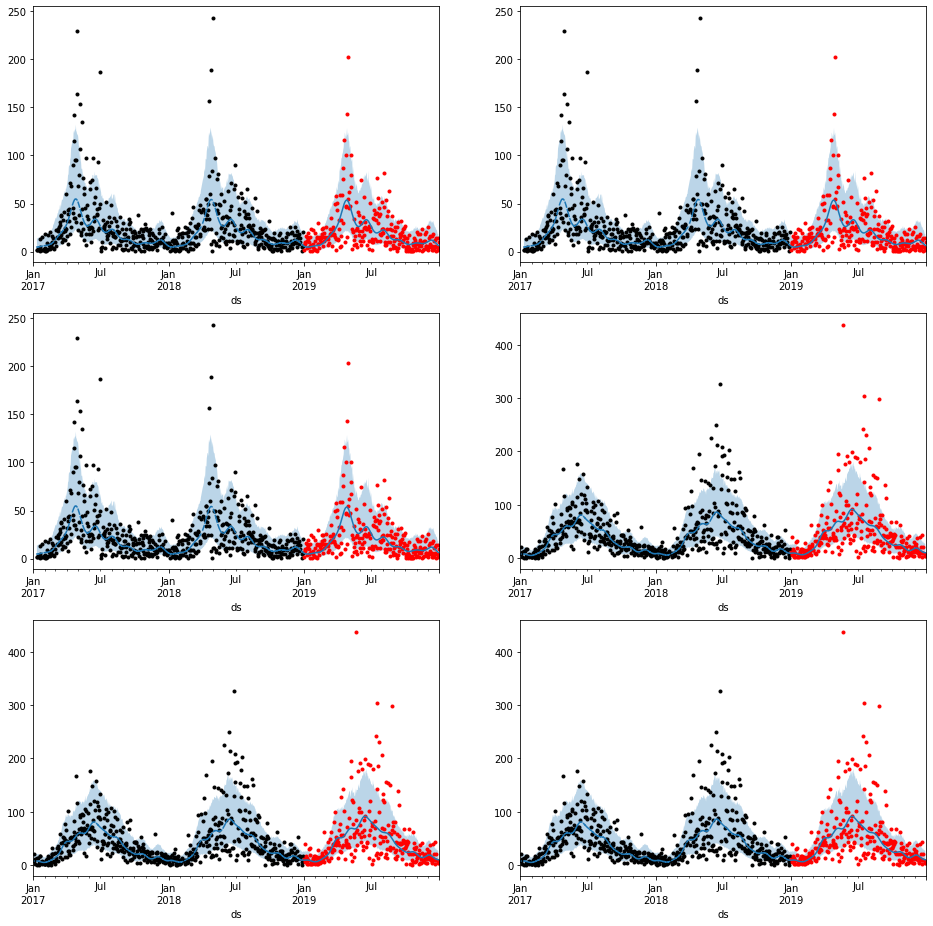

In [108]:
f, axs = plt.subplots(3, 2, figsize=(16,16))
item_ax = zip(fcst.columns.get_level_values(0), np.ravel(axs))
for item, ax in item_ax:
    utils.plot_fcst(fcst[item], train=train[item], test=test[item], ax=ax)

# Forecast por producto y región

In [175]:
u_producto_region = pd.pivot_table(
    data, 
    values="u pedidas", 
    index="tiempo", 
    columns=["producto", "sucursal"], 
    aggfunc="sum").asfreq("D")

In [176]:
u_producto_region = u_producto_region.reindex(index=pd.date_range(start="2017-01-01", end="2019-12-31", freq="D"))

In [223]:
u_producto_region.head()

producto      16034   16061            16062            16070           \
sucursal   santa fe neuquen santa fe neuquen santa fe neuquen santa fe   
2017-01-01      NaN     NaN      NaN     NaN      NaN     NaN      NaN   
2017-01-02      NaN     NaN      7.0     NaN      1.0     NaN     25.0   
2017-01-03      NaN     NaN     21.0     NaN      NaN     NaN     27.0   
2017-01-04      NaN     NaN      NaN     NaN      NaN     NaN      8.0   
2017-01-05      NaN     NaN      3.0     NaN      NaN     NaN      6.0   

producto     16071            16075  ...   44158            90739           \
sucursal   neuquen santa fe neuquen  ... neuquen santa fe neuquen santa fe   
2017-01-01     NaN      NaN     NaN  ...     NaN      NaN     NaN      NaN   
2017-01-02     NaN     11.0     NaN  ...     NaN      NaN     NaN      4.0   
2017-01-03     NaN      2.0     NaN  ...     NaN      NaN     NaN      3.0   
2017-01-04     NaN      4.0     NaN  ...     NaN      1.0     NaN      NaN   
2017-01-05     NaN      3.0     NaN  ...     NaN      1.0     NaN      NaN   

producto     90740            90745            90746           
sucursal   neuquen santa fe neuquen santa fe neuquen santa fe  
2017-01-01     NaN      NaN     NaN      NaN     NaN      NaN  
2017-01-02     NaN      1.0     NaN      NaN     NaN      NaN  
2017-01-03     NaN      2.0     NaN      NaN     NaN      NaN  
2017-01-04     NaN      NaN     NaN      NaN     NaN      NaN  
2017-01-05     NaN      1.0     NaN      NaN     NaN      NaN  

[5 rows x 120 columns]

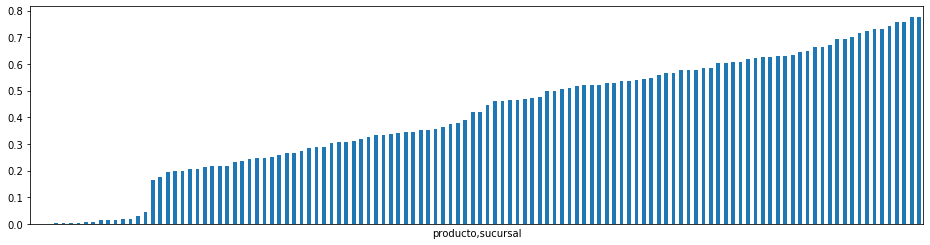

In [183]:
utils.get_amount_info(u_producto_region).plot(kind="bar", figsize=(16,4))
plt.xticks(ticks=[]);

In [227]:
u_producto_region_forecastable = utils.get_forecastables(u_producto_region, T=0.5, N=12).sort_index(axis=1)

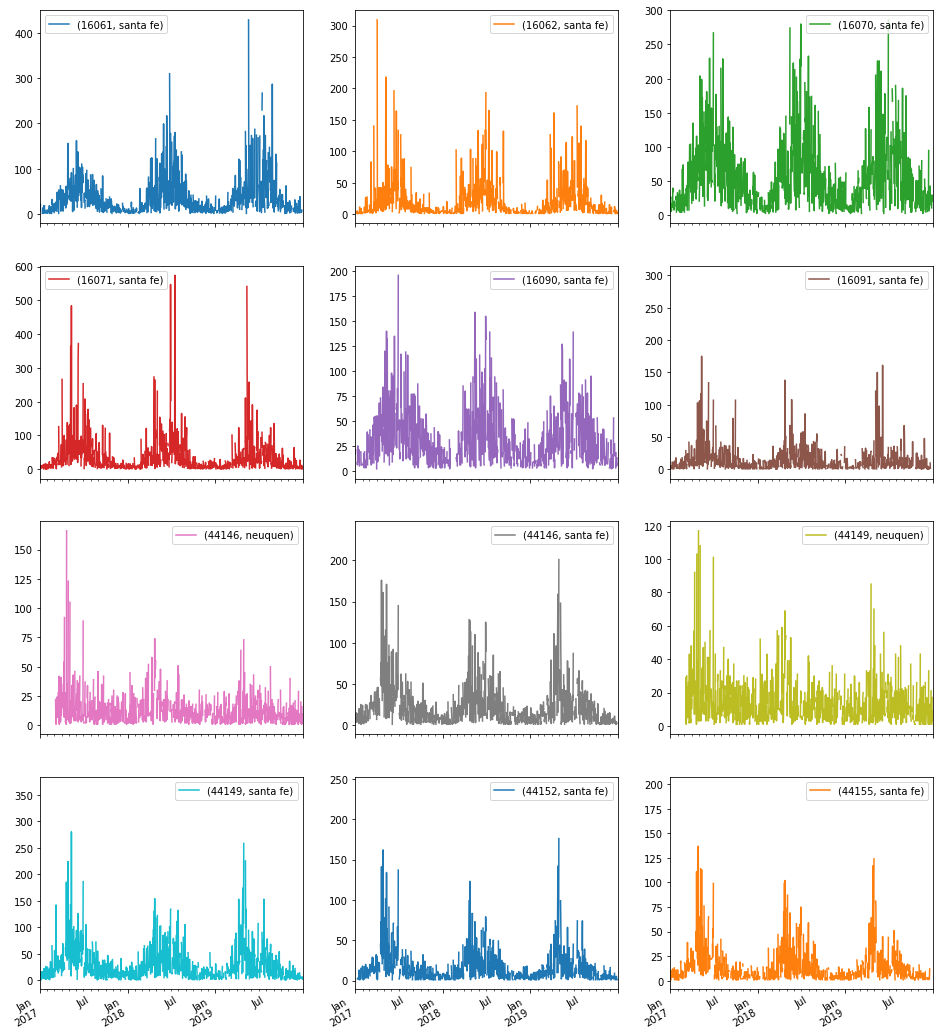

In [229]:
utils.plot_grid(u_producto_region_forecastable, n_cols=3, figsize=(16, 20))

In [195]:
train, test = u_producto_region_forecastable[:"2018-12-31"], u_producto_region_forecastable["2019-01-01":]

In [216]:
config = {
    "yearly_seasonality":10, 
    "weekly_seasonality":False, 
    "daily_seasonality":False}

model = ProphetForecaster(prophet_config=config)
model.fit(train)
fcst = model.predict(steps=365).asfreq("D")

Fitting...


12 of 12|#################################################################|100%


Forecasting...


12 of 12|#################################################################|100%


In [217]:
fcst.head(10)

16061                           16062                        \
            santa fe                        santa fe                         
                yhat yhat_lower yhat_upper      yhat yhat_lower yhat_upper   
ds                                                                           
2017-01-02  5.386853   1.470369  17.532139  2.229475   0.772193   7.208125   
2017-01-03  5.406998   1.596451  16.487260       NaN        NaN        NaN   
2017-01-04       NaN        NaN        NaN       NaN        NaN        NaN   
2017-01-05  5.441283   1.716096  15.530339       NaN        NaN        NaN   
2017-01-06       NaN        NaN        NaN  2.306941   0.736628   6.605861   
2017-01-07  5.456751   1.660817  16.666554       NaN        NaN        NaN   
2017-01-08       NaN        NaN        NaN       NaN        NaN        NaN   
2017-01-09       NaN        NaN        NaN  2.358351   0.835838   7.107043   
2017-01-10       NaN        NaN        NaN  2.370805   0.778480   7.037589   
2017-01-11  5.395641   1.554423  16.869570  2.379988   0.783934   7.836502   

                16070                           16071  ...      44149  \
             santa fe                        santa fe  ...    neuquen   
                 yhat yhat_lower yhat_upper      yhat  ... yhat_upper   
ds                                                     ...              
2017-01-02  14.953977   4.385615  39.643789  5.567765  ...        NaN   
2017-01-03  14.656313   4.371010  38.469094  5.496262  ...        NaN   
2017-01-04  14.414836   4.643764  40.871722  5.432328  ...        NaN   
2017-01-05  14.227067   4.306866  37.670647  5.375307  ...        NaN   
2017-01-06  14.089813   4.191333  38.424325       NaN  ...        NaN   
2017-01-07  13.999225   4.147530  39.741729  5.279075  ...        NaN   
2017-01-08        NaN        NaN        NaN       NaN  ...        NaN   
2017-01-09        NaN        NaN        NaN  5.201425  ...        NaN   
2017-01-10  13.960102   3.999651  38.394133  5.167639  ...        NaN   
2017-01-11  14.006174   4.026675  37.948232  5.136246  ...        NaN   

                                               44152                        \
            santa fe                        santa fe                         
                yhat yhat_lower yhat_upper      yhat yhat_lower yhat_upper   
ds                                                                           
2017-01-02  7.859500   1.994782  24.205215       NaN        NaN        NaN   
2017-01-03  7.707466   2.041851  26.258169       NaN        NaN        NaN   
2017-01-04  7.570713   2.073831  24.166100       NaN        NaN        NaN   
2017-01-05  7.449867   1.776365  25.100444       NaN        NaN        NaN   
2017-01-06  7.345328   1.882404  24.509343       NaN        NaN        NaN   
2017-01-07  7.257265   2.001028  24.281261       NaN        NaN        NaN   
2017-01-08       NaN        NaN        NaN       NaN        NaN        NaN   
2017-01-09       NaN        NaN        NaN       NaN        NaN        NaN   
2017-01-10  7.090192   1.850116  24.668962       NaN        NaN        NaN   
2017-01-11  7.065153   1.737226  23.906121  3.503355   1.010046  10.464327   

               44155                        
            santa fe                        
                yhat yhat_lower yhat_upper  
ds                                          
2017-01-02  3.829905   1.179135  11.903995  
2017-01-03       NaN        NaN        NaN  
2017-01-04  3.911377   1.258183  11.789900  
2017-01-05  3.942978   1.346533  11.084507  
2017-01-06       NaN        NaN        NaN  
2017-01-07  3.979607   1.432747  12.329618  
2017-01-08       NaN        NaN        NaN  
2017-01-09       NaN        NaN        NaN  
2017-01-10  3.954297   1.419594  12.704286  
2017-01-11  3.923883   1.253369  12.368685  

[10 rows x 36 columns]

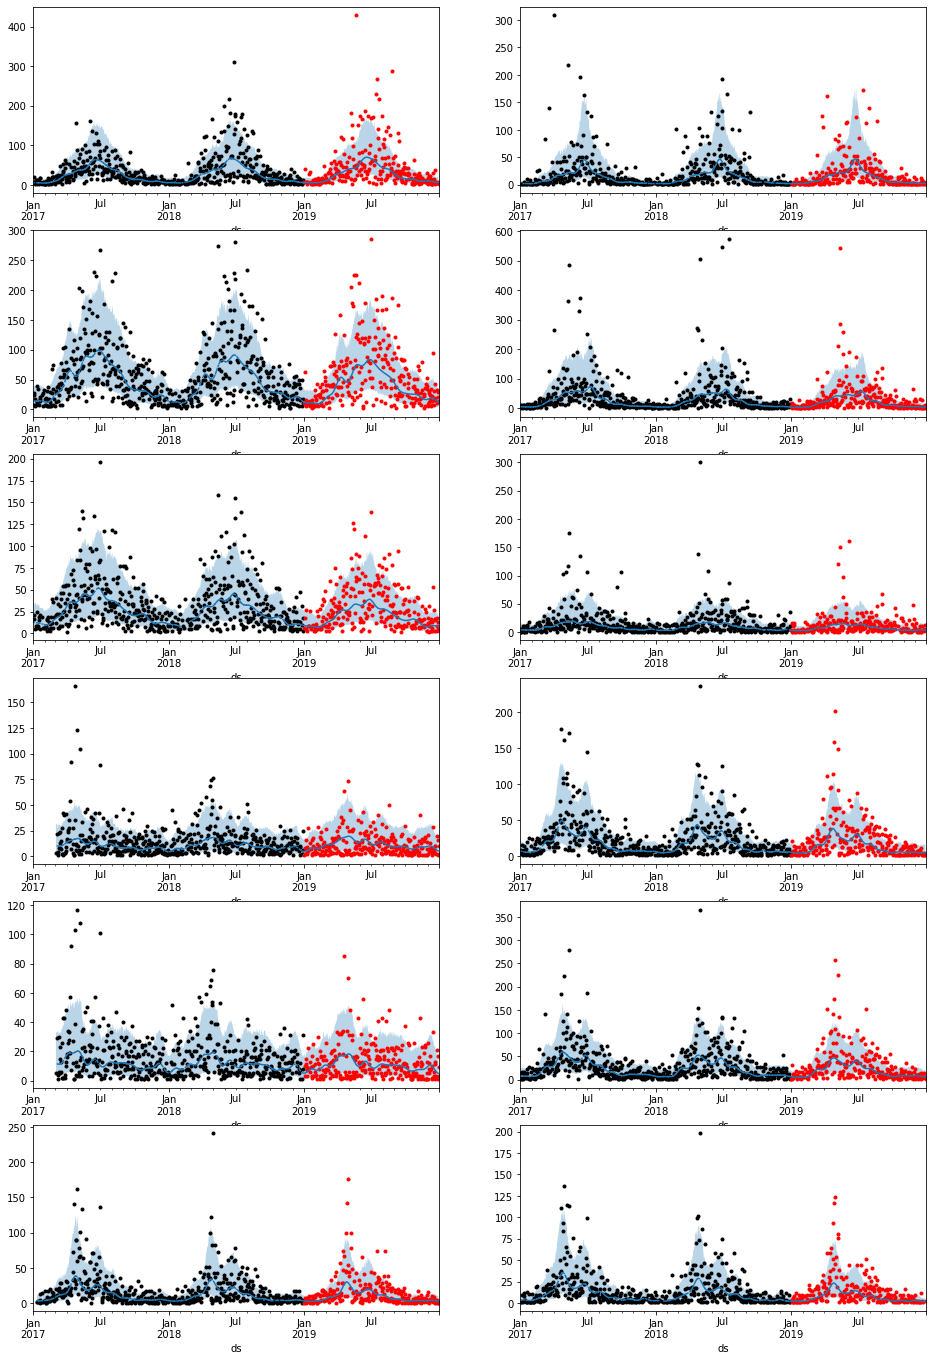

In [218]:
f, axs = plt.subplots(6, 2, figsize=(16,24))
items = fcst.columns.droplevel(2).drop_duplicates()
item_ax = zip(items, np.ravel(axs))
for item, ax in item_ax:
    utils.plot_fcst(fcst[item], train=train[item], test=test[item], ax=ax)

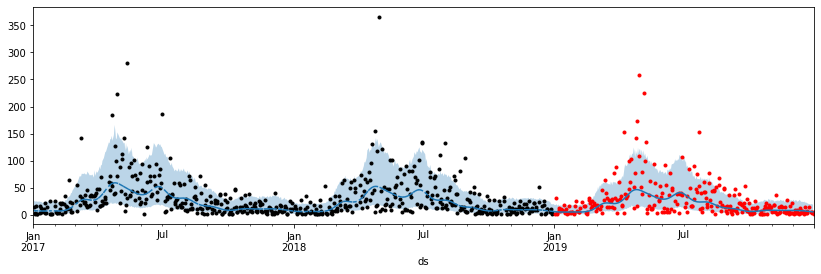

In [220]:
item = (44149, "santa fe")
utils.plot_fcst(fcst[item], train[item], test[item])